### Resume and Job Matching - Demo version

### The code below receives a resume as an input in the format of pdf.
### The code putput is the top matching jobs from the dataset with that resume.

#### Step 1 - Import packages

In [1]:
from __future__ import unicode_literals
from gensim.summarization import keywords
import pandas as pd

import nltk
import string
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
import unicodedata
import math
import bytes
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import seaborn as sns
from collections import Counter

import gensim
from gensim.models import Word2Vec
import logging


from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import sys
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import XMLConverter, HTMLConverter, TextConverter
from pdfminer.layout import LAParams

from io import StringIO

#### Step 2 - Set up the directory

In [13]:
os.chdir(r"C:\Users\khans\Insight\My code")

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [10]:
import pickle

saved_model = pickle.dumps(model) 


model = pickle.loads(saved_model) 

### Demo code

Enter resume name: Sherry Khansari


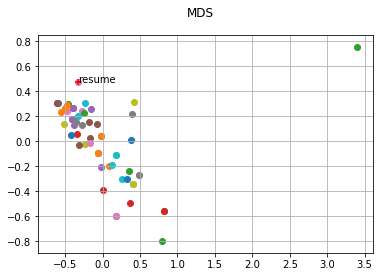

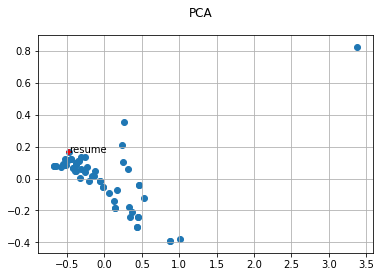

,Company,Postition,Cosine Distances,Keywords,Job Description
55,Raytheon,Statistician / Data Scientist,0.535784,opportun veteran action,[<p>Raytheon is an Equal Opportunity/Affirmati...
54,Raytheon,Statistician/Data Scientist,0.535784,opportun veteran action,[<p>Raytheon is an Equal Opportunity/Affirmati...
0,IBM,Information Technology Intern,0.515986,scienc internship skill chief,The IBM Chief Information Officer(CIO) organi...
1,Mary Kay,NSD Services Intern Undergrad,0.503288,forc social experi people environ public rel e...,Intern will learn the inner workings of both ...
3,Deloitte,"Summer Associate - Strategy & Operations, MBA ...",0.481013,develop frequent business issu protected veter...,Deloitte Consulting LLP is one of the worldâ€...


In [21]:
def pdfparser(data):

    fp = open(data, 'rb')
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    # removed from the line above: , codec=codec
    # Create a PDF interpreter object.
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    # Process each page contained in the document.

    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        data =  retstr.getvalue()

    return data
    
with open('resumeconverted.txt','w') as f:
    f.write(pdfparser(str(input("Enter resume name: ")+".pdf")))
    
df = pd.read_csv("Data_Demo.csv")

jd = df['Job Description'].tolist()
companies = df['company'].tolist()
positions = df['position'].tolist()


with open('resumeconverted.txt','r') as f:
    resume = f.read()
    
jd.append(resume)

##-------------------
class MyCountVectorizer:
    def __init__(self, docs):
        self.corpus = self.normalize_corpus(docs)
        self.make_features()
        self.make_matrix()
        
    def normalize_corpus(self, docs):    
        #table = string.maketrans(string.punctuation, 
         #                        len(string.punctuation) * ' ')
        
        #table = str.rstrip(string.punctuation, 
        #                         len(string.punctuation) * ' ')
        
        table = str.maketrans('', '', string.punctuation)
        
        
        
        norm_docs = []
        for doc_raw in docs:
            doc = filter(lambda x: x in string.printable, doc_raw)
            '''
            doc = ''
            for x in doc_raw:
                if x in string.printable:
                    doc += x
            '''
            doc = str(doc).translate(table).lower()
            norm_docs.append(doc)
        #self.corpus = norm_docs
        return norm_docs
        
    def make_features(self):
        ''' create vocabulary set from the corpus '''
        stopwords = nltk.corpus.stopwords.words('english')
        self.features = set()
        for doc in self.corpus:
            for word in doc.split():
                if word not in stopwords:
                    self.features.add(word)
        #self.features = set([word for doc in self.corpus for word in doc.split() if word not in stopwords])
        self.features = sorted(list(self.features))

    def make_matrix(self):
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                doc_vec.append(tf)
            self.matrix.append(doc_vec)

    def term_freq(self, term, document):
        words = document.split()
        count = 0
        for word in words:
            if word == term:
                count += 1
        return count
    
    def print_matrix(self):
        for vec in self.matrix:
            print(vec)

    def get_matrix(self):
        return self.matrix
    
    def get_features(self):
        return self.features
    
    def get_density(self):
        ''' get the density (# of non-zero elements / # all elements )'''
        counter = 0
        total = 0
        for row in self.matrix:
            for item in row:
                if item != 0:
                    counter += 1
                total += 1
        return 1.0 * counter / total
    
##---------------------------------
class MyTfIdfVectorizer(MyCountVectorizer):
    ''' inherits from MyCountVectorizer'''

    def make_matrix(self):
        'overriding method'
        self.matrix = []
        for doc in self.corpus:
            doc_vec = []
            for word in self.features:
                tf = self.term_freq(word, doc)
                idf = self.inverse_document_freq(word)
                doc_vec.append(tf * idf)
            #self.matrix.append(doc_vec)
            total = sum(doc_vec)
            doc_vec_norm = [i/total for i in doc_vec]
            self.matrix.append(doc_vec_norm)

    def inverse_document_freq(self, term):
        doc_count = 0
        for document in self.corpus:
            term_count = self.term_freq(term, document)
            if term_count > 0:
                doc_count += 1
        return math.log( 1.0 * len(self.corpus) / doc_count)
    
    
##---------------------------------------------------------
def plot_mds(mean_vec):   
    from sklearn.manifold import MDS
    data = mean_vec
    mds = MDS(n_components=2, random_state=1)
    pos = mds.fit_transform(data)
    xs,ys = pos[:,0], pos[:,1]
    for x, y in zip(xs, ys):
        plt.scatter(x, y)
    #    plt.text(x, y, name)
    #pos2 = mds.fit_transform(model.infer_vector(resume))
    #xs2,ys2 = pos2[:,0], pos2[:,1]
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.suptitle('MDS')
    plt.grid()
    plt.savefig('distance_MDS_improved.png')
    plt.show()

def plot_pca(meav_vec):
    from sklearn.decomposition import PCA
    data = mean_vec
    pca = PCA(n_components=2) #, whiten=True
    X = pca.fit_transform(data)
    xs,ys =X[:,0], X[:,1]
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(xs[-1], ys[-1], c='Red', marker='+')
    plt.text(xs[-1], ys[-1],'resume')
    plt.grid()
    plt.suptitle('PCA')
    plt.savefig('distance_PCA_improved.png')
    plt.show()
    
##---------------------------------------------------

# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

##---------------------------------------------------
myvec = MyTfIdfVectorizer(jd)


stopwords = nltk.corpus.stopwords.words('english')

imp = ['java']
vec = []

for j in jd:
    x = j.translate(str.maketrans('', '', string.punctuation))
    y = x.translate(str.maketrans('', '', string.digits))
    jd_vector = []
    i = 0
    
    for word in y.split():
        if word.lower() not in stopwords and len(word)>2 and word not in imp:
            try:
                x = model[word]
                idx = myvec.get_features().index(word)
                z = myvec.get_matrix()[i][idx]
                lst = [a * z for a in x]
                jd_vector.append(lst)
            except:
                continue
    
        else:
            try:
                x = model[word]
                lst = [a * 2 for a in x]
                jd_vector.append(lst)
            except:
                continue
    i+=1
    vec.append(jd_vector)

    
##-----------------------------------------------------
mean_vec = []
for j in vec:
    mean = []
    for i in range(300):
        accum =0
        for word in j:
            accum += word[i]
        mean.append(1.0*accum/len(word))
    mean_vec.append(mean)
data = mean_vec

plot_mds(mean_vec)
plot_pca(mean_vec)

##-----------------------------------------------------
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
cos_dist =[]

data[-1] = np.array(data[-1])
data[-1] = data[-1].reshape(1,-1)

for vec in data[:-1]:
    vec = np.array(vec)
    vec = vec.reshape(1,-1)
    cos_dist.append(float(cosine_distances(vec,data[-1])))
    

ps = PorterStemmer()
key_list =[]

for j in jd[:-1]:
    key = ''
    w = set()
    for word in keywords(j).split('\n'):
        w.add(ps.stem(word))
    for x in w:
        key += '{} '.format(x)
    key_list.append(key)
##------------------------------------------------------
summary = pd.DataFrame({
        'Company': companies,
        'Postition': positions,
        'Cosine Distances': cos_dist,
        'Keywords': key_list,
    'Job Description': jd[:-1]
    })

z =summary.sort_values('Cosine Distances', ascending=False)
z.to_csv('Summary_demo.csv',encoding="utf-8")
z.head()